# Barycenters of persistence diagrams

Theo Lacombe

https://tlacombe.github.io/

## A statistical descriptor in the persistence diagram space

This tutorial presents the concept of barycenter, or __Fréchet mean__, of a family of persistence diagrams. Fréchet means, in the context of persistence diagrams, were initially introduced in the seminal papers:
- Probability measures on the space of persistence diagrams, by Mileyko, Mukherjee, and Harer. https://math.hawaii.edu/~yury/papers/probpers.pdf ,
- Fréchet means for distributions of persistence diagrams, by Turner, Mileyko, Mukherjee and Harer, https://arxiv.org/pdf/1206.2790.pdf 
and later studied in https://arxiv.org/pdf/1901.03048.pdf (theoretical viewpoint) and https://arxiv.org/pdf/1805.08331.pdf (computational viewpoint).

## Motivation and mathematical formulation

Recall that given an object $X$, say a point cloud embedded in the Euclidean space $\mathbb{R}^d$, one can compute its persistence diagram $\mathrm{Dgm}(X)$ which is a point cloud supported on a half-plane $\Omega \subset \mathbb{R}^2$ (see this tutorial https://github.com/GUDHI/TDA-tutorial/blob/master/Tuto-GUDHI-persistence-diagrams.ipynb for an introduction to persistence diagrams).

Now, consider that instead of building one diagram $\mathrm{Dgm}(X)$ from one object $X$, you observe a collection of objects $X_1 \dots X_n$ and compute their respective diagrams, let's call them $\mu_1 \dots \mu_n$. How can you build a statistical summary of this information? 

Fréchet means is one way to do so. It mimics the notion of arithmetic mean in metric spaces. First, recall that the space of persistence diagrams, equipped with either the bottleneck (https://gudhi.inria.fr/python/latest/bottleneck_distance_user.html) or the Wasserstein (https://gudhi.inria.fr/python/latest/wasserstein_distance_user.html) metrics is **not** a linear space. Therefore, the notion of arithmetic mean cannot be faithfully transposed to the context of persistence diagrams.

To overcome this limitation, one relies on _Fréchet means_. In Euclidean spaces, one of the characterization of the arithmetic mean 
$$ \overline{x} = \frac{1}{n} \sum_{i=1}^n x_i $$
of a sample $x_1 \dots x_n \in \mathbb{R}^d$ is that it minimizes the _variance_ of the sample, that is the map
$$\mathcal{E} : x \mapsto \sum_{i=1}^n \|x - x_i \|_2^2 $$
has a unique minimizer, that turns out to be $\overline{x}$.

Although the former formula does not make sense in general metric spaces, the map $\mathcal{E}$ can still be defined, in particular in the context of persistence diagrams. Therefore, a _Fréchet mean_ of $\mu_1 \dots \mu_n$ is any minimizer, should it exist, of the map
$$ \mathcal{E} : \mu \mapsto \sum_{i=1}^n d_2(\mu, \mu_i)^2, $$
where $d_2$ denotes the so-called Wasserstein-2 distance between persistence diagrams.

It has been proved that Fréchet means of persistence diagrams always exist in the context of averaging finitely many diagrams. Their computation remains however challenging.

## A Lagrangian algorithm

We showcase here one of the algorithm used to _estimate_ barycenters of a (finite) family of persistence diagrams (note that their exact computation is intractable in general). This algorithm was introduced by Turner et al. (https://arxiv.org/pdf/1206.2790.pdf) and adopts a _lagrangian_ perspective. Roughly speaking (see details in their paper), this algorithm consists in iterating the following: 

- Let $\mu$ be a current estimation of the barycenter of $\mu_1 \dots \mu_n$.
- (1) Compute $\sigma_i$ ($1 \leq i \leq n$) the optimal (partial) matching between $\mu$ and $\mu_i$.
- (2) For each point $x$ of the diagram $\mu$, apply $x \mapsto \mathrm{mean}((\sigma_i(x))_i)$, where $\mathrm{mean}$ is the arithemtic mean in $\mathbb{R}^2$.
- (3) If $\mu$ didn't change, return $\mu$. Otherwise, go back to (1).

This algorithm is proved to converge ($\mathcal{E}$ decreases at each iteration) to a _local_ minimum of the map $\mathcal{E}$. Indeed, the map $\mathcal{E}$ is **not convex**, which can unfortunately lead to arbritrary bad local minima. Furthermore, its combinatorial aspect (one must compute $n$ optimal partial matching at each iteration step), makes it too computationally expensive when dealing with a large number of large diagrams. It is however a fairly decent attempt when dealing with few diagrams with few points.

The solution $\mu^*$ returned by the algorithm is a persistence diagram with the following property:
each point $x \in \mu^*$ is the mean of one point (or the diagonal) $\sigma_i(x)$ in each of the $\mu_i$s. These are called _groupings_.

**Note:** This algorithm is said to be based on a _Lagrangian_ approach by opposition to _Eulerian_ , from fluid dynamics formalism (https://en.wikipedia.org/wiki/Lagrangian_and_Eulerian_specification_of_the_flow_field). Roughly speaking, Lagrangian models track the position of each particule individually (here, the points in the barycenter estimate), while Eulerian models instead measure the quantity of mass that is present in each location of the space. We will present in a next version of this tutorial an Eulerian approach to solve (approximately) this problem.

## Illustration

### Imports and preliminary tests

In [1]:
import gudhi
print("Current gudhi version:", gudhi.__version__)
print("Version >= 3.2.0 is required for this tutorial")

Current gudhi version: 3.11.0
Version >= 3.2.0 is required for this tutorial


In [2]:
from gudhi.wasserstein.barycenter import lagrangian_barycenter as bary
from gudhi.persistence_graphical_tools import plot_persistence_diagram

import numpy as np
import matplotlib.pyplot as plt

### Exemple

Let us consider three persistence diagrams.

In [3]:
diag1 = np.array([[0., 1.], [0, 2], [1, 2], [1.32, 1.87], [0.7, 1.2]])
diag2 = np.array([[0, 1.5], [0.5, 2], [1.2, 2], [1.3, 1.8], [0.4, 0.8]])
diag3 = np.array([[0.2, 1.1], [0.1, 2.2], [1.3, 2.1], [0.5, 0.9], [0.6, 1.1]])

diags = [diag1, diag2, diag3]

Text(0.5, 1.0, 'Set of 3 persistence diagrams')

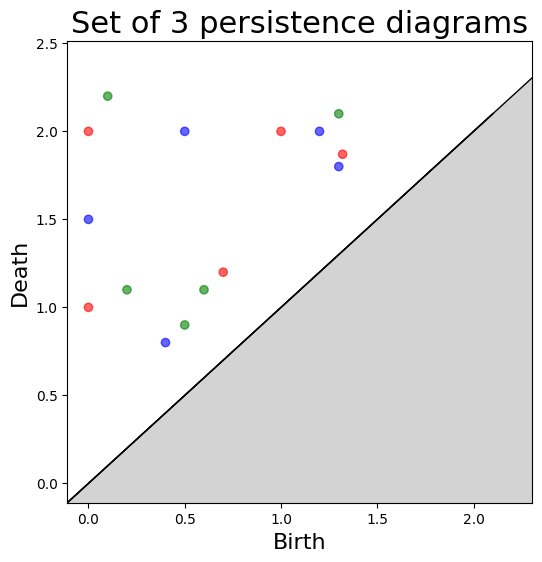

In [4]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
colors=['r', 'b', 'g']
for diag, c in zip(diags, colors):
    plot_persistence_diagram(diag, axes=ax, colormap=c)
ax.set_title("Set of 3 persistence diagrams", fontsize=22)

Now, let us compute (more precisely, estimate) a barycenter of `diags`.

Using the verbose option, we can get access to a `log` (dictionary) that contains complementary informations.

In [5]:
b, log = bary(diags, 
         init=0,
         verbose=True)  # we initialize our estimation on the first diagram (the red one.)

In [6]:
print("Energy reached by this estimation of the barycenter: E=%.2f." %log['energy'])
print("Convergenced made after %s steps." %log['nb_iter'])

Energy reached by this estimation of the barycenter: E=0.47.
Convergenced made after 2 steps.


Using the `groupings` provided in logs, we can have a better visibility on what is happening.

In [7]:
G = log["groupings"]

def proj_on_diag(x):
    return ((x[1] + x[0]) / 2, (x[1] + x[0]) / 2)

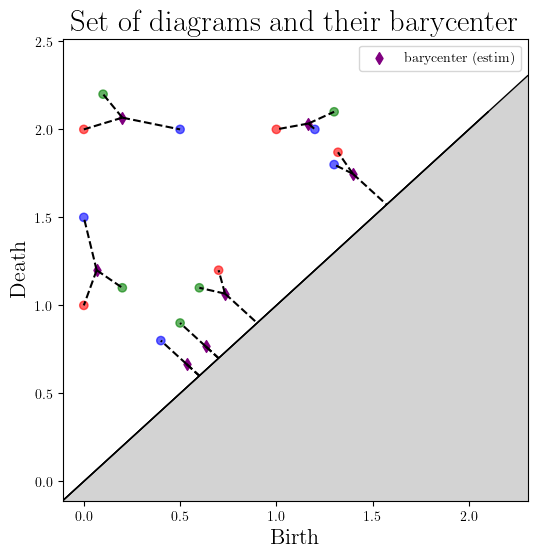

In [8]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
colors = ['r', 'b', 'g']

for diag, c in zip(diags, colors):
    plot_persistence_diagram(diag, axes=ax, colormap=c)

def plot_bary(b, diags, groupings, axes):
    # n_y = len(Y.points)
    for i in range(len(diags)):
        indices = G[i]
        n_i = len(diags[i])

        for (y_j, x_i_j) in indices:
            y = b[y_j]
            if y[0] != y[1]:
                if x_i_j >= 0:  # not mapped with the diag
                    x = diags[i][x_i_j]
                else:  # y_j is matched to the diagonal
                    x = proj_on_diag(y)
                ax.plot([y[0], x[0]], [y[1], x[1]], c='black',
                        linestyle="dashed")

    ax.scatter(b[:,0], b[:,1], color='purple', marker='d', label="barycenter (estim)")
    ax.legend()
    ax.set_title("Set of diagrams and their barycenter", fontsize=22)

plot_bary(b, diags, G, axes=ax)

Note that, as the problem is not convex, the output (and its quality, i.e. energy) might depend on optimization.

Energy: lower is better.

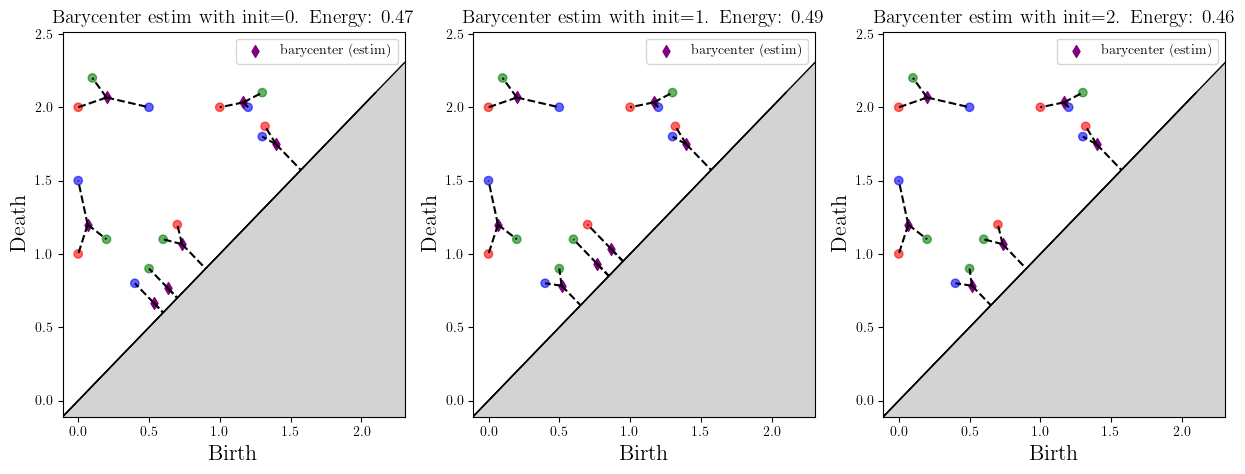

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

colors = ['r', 'b', 'g']

for i, ax in enumerate(axs):
    for diag, c in zip(diags, colors):
        plot_persistence_diagram(diag, axes=ax, colormap=c)

    b, log = bary(diags, init=i, verbose=True)
    e = log["energy"]
    G = log["groupings"]
    # print(G)
    plot_bary(b, diags, groupings=G, axes=ax)
    ax.set_title("Barycenter estim with init=%s. Energy: %.2f" %(i, e), fontsize=14)